In [81]:
from typing import TypedDict, List, Literal
from langchain.prompts import PromptTemplate
from langchain_community.vectorstores import Chroma
from langchain_nvidia_ai_endpoints import NVIDIAEmbeddings, ChatNVIDIA
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_core.output_parsers import StrOutputParser
from langgraph.graph import StateGraph, END
from tavily import TavilyClient
from dotenv import load_dotenv
import os
load_dotenv()

True

In [82]:
os.environ["NVIDIA_API_KEY"] = os.getenv("NVIDIA_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

In [83]:

# Load and prepare documents
loader = PyMuPDFLoader("D:\\Code\\GIt repo\\internship+gen ai\\quadrag\\Hands-on-ML-ml.pdf")
docs = loader.load()
splitter = RecursiveCharacterTextSplitter(chunk_size=400, chunk_overlap=50)
chunks = splitter.split_documents(docs)

vectorstore = Chroma(
    collection_name="hands-on-ml",
    embedding_function=NVIDIAEmbeddings(),
    persist_directory="hands-on-ml1"
)
retriever = vectorstore.as_retriever()

# LLM
llm = ChatNVIDIA(model="mixtral_8x7b")

# State definition
class AgentState(TypedDict):
    question: str
    documents: List[str]
    generation: str
    should_rewrite: bool
    is_hallucination: bool
    answer_meets_question: bool
    route: str


d:\ana\envs\langchain_env\lib\site-packages\langchain_nvidia_ai_endpoints\_statics.py:810: UserWarning: Model mixtral_8x7b is deprecated. Using mistralai/mixtral-8x7b-instruct-v0.1 instead.
  warnings.warn(


In [84]:

prompt = PromptTemplate(
    template="""
    You are Professional Book Reader and you are reading a book called "Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow" by Aurélien Géron.
    As a reader user I will ask you questions about the book and you will answer them based on the context of the book.
    Here is the context of the book: {context}
    
    Also here is some advice for you:
    1. Always answer the question based on the context of the book.
    2. If the question is not related to the book, say "I don't know".
    3. If the question is not clear, ask for clarification.
    4. You are a professional book reader, so you should answer the question in a professional way also if user needs explanation then explain like a Great Professor of prestigious University explain with Real-world example(s).
    5. If the question is about a specific chapter, mention the chapter number and title in your answer.
    6. If need some Mathematical formula to answer the question then use LaTeX format to write the formula.
    
    Here is the question: {question}
    Answer the question based on the context of the book.
    """,
    input_variables=["context", "question"],
)


rewrite_prompt = PromptTemplate(
    template="Rewrite this question to be more specific:\n{question}",
    input_variables=["question"]
)

hallucination_check_prompt = PromptTemplate(
    template="""
Check if this answer is fully supported by the context.

Context:
{context}

Answer:
{generation}

Reply with: "No Hallucination" or "Hallucination Detected"
""", input_variables=["context", "generation"]
)


In [85]:
query_analysis_prompt = PromptTemplate(
    template="""Analyze the question and determine if it can be answered with the provided context.
Context:{context}
Question: {question}""",
    input_variables=["context", "question"]
)

# Define the query analysis chain
query_analysis_chain = query_analysis_prompt | llm | StrOutputParser()

def query_analysis(state: AgentState) -> AgentState:
    print("🔍 Query Analysis...")
    context = "\n\n".join(doc.page_content for doc in docs[:5])  # Use first few docs for context
    result = query_analysis_chain.invoke({
        "context": context,
        "question": state["question"]
    })
    
    # Route to index search if response indicates question can be answered from book
    return {**state, "route": "index" if "can be answered" in result.lower() else "web"}

In [86]:

# Chains
qa_chain = prompt | llm | StrOutputParser()
rewrite_chain = rewrite_prompt | llm | StrOutputParser()
hallucination_chain = hallucination_check_prompt | llm | StrOutputParser()




def retrieve_docs(state: AgentState) -> AgentState:
    print("📚 Retrieving documents...")
    docs = retriever.invoke(state["question"])
    return {**state, "documents": docs}

def grade_docs(state: AgentState) -> AgentState:
    print("📝 Grading document relevance...")
    return {**state, "should_rewrite": not bool(state["documents"])}

def generate_answer(state: AgentState) -> AgentState:
    print("🧠 Generating book-based answer...")
    context = "\n\n".join(doc.page_content for doc in state["documents"])
    generation = qa_chain.invoke({"context": context, "question": state["question"]})
    return {**state, "generation": generation}

def check_hallucination(state: AgentState) -> AgentState:
    print("🔍 Checking for hallucinations...")
    context = "\n\n".join(doc.page_content for doc in state["documents"])
    result = hallucination_chain.invoke({"context": context, "generation": state["generation"]})
    return {**state, "is_hallucination": "Hallucination Detected" in result}

def check_answers_question(state: AgentState) -> AgentState:
    print("✅ Checking if answer meets question...")
    valid = state["generation"] and "I don't know" not in state["generation"]
    return {**state, "answer_meets_question": valid}

def rewrite_question(state: AgentState) -> AgentState:
    print("🔁 Rewriting question...")
    new_q = rewrite_chain.invoke({"question": state["question"]})
    return {**state, "question": new_q, "should_rewrite": False}



# Conditions
def route_condition(state: AgentState) -> Literal["index", "web"]:
    return state["route"]

def grade_condition(state: AgentState) -> Literal["yes", "no"]:
    return "yes" if not state["should_rewrite"] else "no"

def hallucination_condition(state: AgentState) -> Literal["yes", "no"]:
    return "no" if not state["is_hallucination"] else "yes"

def check_answer_condition(state: AgentState) -> Literal["yes", "no"]:
    return "yes" if state["answer_meets_question"] else "no"


In [87]:
def web_generate(state: AgentState) -> AgentState:
    print("🌐 Generating web-based answer...")
    tavily_client = TavilyClient()  # API key will be taken from environment variable
    try:
        search_results = tavily_client.search(
            query=state["question"],
            search_depth="basic",
            max_results=2
        )
        
        if search_results and len(search_results.get('results', [])) > 0:
            # Extract content from the first few results
            content = []
            for result in search_results['results'][:2]:
                content.append(f"- {result.get('title', '')}: {result.get('content', '')}")
            
            answer = "\n".join(content)
        else:
            answer = "No relevant information found on the web."
            
    except Exception as e:
        print(f"Error during web search: {str(e)}")
        answer = "Sorry, I encountered an error while searching the web."

    return {**state, "generation": answer}

In [88]:

# Graph setup
workflow = StateGraph(AgentState)
workflow.add_node("query_analysis", query_analysis)
workflow.add_node("retrieve", retrieve_docs)
workflow.add_node("grade", grade_docs)
workflow.add_node("generate", generate_answer)
workflow.add_node("hallucination", check_hallucination)
workflow.add_node("check_answer", check_answers_question)
workflow.add_node("rewrite", rewrite_question)
workflow.add_node("web_generate", web_generate)

# Routing
workflow.set_entry_point("query_analysis")
workflow.add_conditional_edges("query_analysis", route_condition, {
    "index": "web_generate",
    "web": "retrieve"
})
workflow.add_edge("web_generate", END)
workflow.add_edge("retrieve", "grade")
workflow.add_conditional_edges("grade", grade_condition, {"yes": "generate", "no": "rewrite"})
workflow.add_edge("rewrite", "retrieve")
workflow.add_edge("generate", "hallucination")
workflow.add_conditional_edges("hallucination", hallucination_condition, {"yes": "generate", "no": "check_answer"})
workflow.add_conditional_edges("check_answer", check_answer_condition, {"yes": END, "no": "rewrite"})

app = workflow.compile()


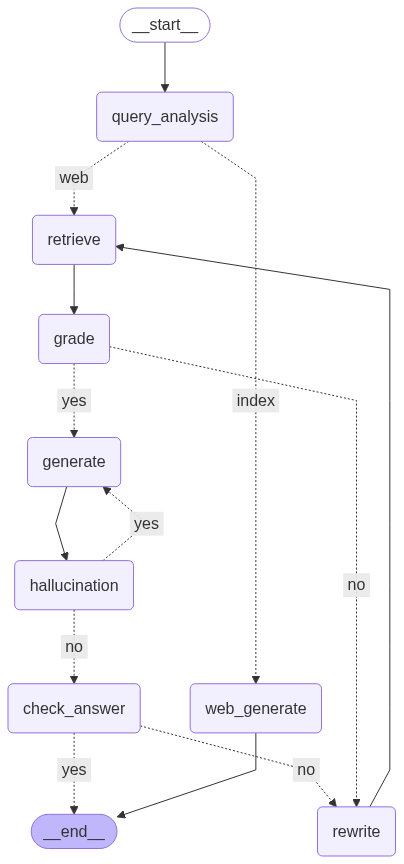

In [89]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [90]:

input_state2 = {"question": "what is the difference between keras and tensorflow?"}
result2 = app.invoke(input_state2)
print("\nfinal Answer:\n", result2["generation"])

🔍 Query Analysis...
📚 Retrieving documents...
📝 Grading document relevance...
🧠 Generating book-based answer...
🔍 Checking for hallucinations...
✅ Checking if answer meets question...

final Answer:
 The book mentions that Keras is a high-level Deep Learning API that can be used with TensorFlow, but it can also be used with other deep learning libraries. Keras provides a simple interface for building and training deep learning models, while TensorFlow is a powerful library for numerical computations that can be used to implement and train these models.

When used together, Keras serves as the high-level API for building and training models, while TensorFlow serves as the underlying engine for performing the computations. This combination is referred to as "multibackend Keras" in the book.

Additionally, TensorFlow 2.0 has adopted Keras as its official high-level API. This means that when you use TensorFlow 2.0, you are effectively using a version of Keras that is integrated with Tensor

In [91]:

input_state2 = {"question": "wwhat is learning rate in deep learning?"}
result2 = app.invoke(input_state2)
print("\nfinal Answer:\n", result2["generation"])

🔍 Query Analysis...
📚 Retrieving documents...
📝 Grading document relevance...
🧠 Generating book-based answer...
🔍 Checking for hallucinations...
✅ Checking if answer meets question...

final Answer:
 The learning rate in deep learning is a hyperparameter that determines how much the weights in a model are adjusted with respect to the loss gradient during training. It controls the size of the steps that the model takes while traversing the loss landscape to find the optimal weights. A properly tuned learning rate can significantly impact the training time and the final performance of the model. If the learning rate is too small, the model may require many iterations to converge to the optimal solution, resulting in slow training (as shown in Figure 4-4 in the book). On the other hand, if the learning rate is too large, the model might overshoot the optimal solution, possibly causing the training to diverge (Figure 4-5). The book mentions power scheduling and exponential scheduling as te

In [92]:

input_state2 = {"question": "wwhat is linear regression?"}
result2 = app.invoke(input_state2)
print("\nfinal Answer:\n", result2["generation"])

🔍 Query Analysis...
📚 Retrieving documents...
📝 Grading document relevance...
🧠 Generating book-based answer...
🔍 Checking for hallucinations...
✅ Checking if answer meets question...

final Answer:
 Linear regression is a statistical model that is used to examine the relationship between two continuous variables. In the context of the book, Chapter 4, it is defined as a model that makes a prediction by computing a weighted sum of the input features, plus a constant called the bias term (also referred to as the intercept term). Mathematically, it is represented as the equation:

`y' = θ0 + θ1*x1 + θ2*x2 + ... + θn*xn`

where `y'` is the predicted value, `x1, x2, ..., xn` are the input features, and `θ0, θ1, ..., θn` are the model's parameters.

In simpler terms, it is a method of fitting a straight line or a plane to a set of data points, with the goal of making the distances between the observed data points and the fitted line as small as possible.

For example, in the real-world, it 